In [76]:
import os
import sys
sys.path.append("./..")
from utils import PROJECT_ROOT, process_Danenberg_clinical_data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import networkx as nx
from matplotlib.lines import Line2D
import pandas as pd
from c_Population_graph.population_graph import construct_PopulationGraph
from d_Patient_subgroups.community_detection import detect_communities
from e_Survival_analysis.survival_analysis import calculate_hazard_ratio
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, logrank_test
from f_Prognosis_relevant_patterns_random_split.overpresented_patterns import calculate_relative_presentation

### Parameters

In [77]:
iteration = 2
PhenoGraph_k =  100
node_label = 'CellType'
size_smallest_cluster  = 10
survival_type = 'Disease-specific'
PopulationGraph_type = 'two_step_knn_graph'
para_dict = {
    'weight_threshold_percentile': 50,
    'knn_k': 30
}
patient_filtering_dict = {
    # 'Clinical Subtype': 'HR+/HER2-'
}

# Discovery

In [78]:
SoftWL_dict= pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Danenberg",
            "Subset_1",
            "SoftWL_dict_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            + "_"
            + node_label
            + ".pkl",
        ),
        "rb",
    ),
)
Patient_IDs = SoftWL_dict["Patient_id"]
Gram_matrix = SoftWL_dict["Gram_matrix"]
Histograms = SoftWL_dict["Histogram"]
Histograms = Histograms/np.sum(Histograms, axis=1, keepdims=True)

clinical = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Danenberg",
        "clinical.csv",
    )
)
clinical = process_Danenberg_clinical_data(clinical)
Patient_Inclusion_mask = np.ones(len(Patient_IDs), dtype=bool)
for feature, included_values in patient_filtering_dict.items():
    Feature = [clinical.loc[clinical['patient_id'] == patient_id, feature].values[0] for patient_id in Patient_IDs]
    patient_inclusion_mask = np.array([feature  == included_values for feature in Feature])
    Patient_Inclusion_mask = Patient_Inclusion_mask * patient_inclusion_mask
Patient_IDs = np.array(Patient_IDs)[Patient_Inclusion_mask]
Gram_matrix = Gram_matrix[Patient_Inclusion_mask, :][:, Patient_Inclusion_mask]
Histograms = Histograms[Patient_Inclusion_mask, :]
print("{} patients are included".format(len(Patient_IDs)))

379 patients are included


### BiGraph

In [79]:
G_population = construct_PopulationGraph(
    Gram_matrix,
    PopulationGraph_type,
    para_dict = para_dict,
)

Community_ids = detect_communities(G_population, size_smallest_cluster, resolution = 1)

In [80]:
Length = [clinical.loc[clinical['patient_id'] == i, survival_type+ ' Survival (Months)'].values[0] for i in Patient_IDs]
Status = [clinical.loc[clinical['patient_id'] == i,  survival_type+ ' Survival Status'].values[0] for i in Patient_IDs]  
DF = pd.DataFrame({"Length": Length, "Status": Status, "Community_ids": Community_ids}).dropna()
Length_ = np.array(DF["Length"])
Status_ = np.array(DF["Status"])
Community_ids_ = np.array(DF["Community_ids"])
Histograms_ = Histograms[DF.index.values, :]
Patient_IDs_ = np.array(Patient_IDs)[DF.index.values]
print("{} patients are included".format(len(Patient_IDs_)))
HR = calculate_hazard_ratio(Length_, Status_, Community_ids_)


HR = sorted(HR, key=lambda x: x["hr"], reverse=True)
Subgroup_ids_ = np.zeros_like(Community_ids_)
for i in range(len(HR)):
    Subgroup_ids_[Community_ids_ == HR[i]["community_id"]] = i + 1
    HR[i]["subgroup_id"] = i + 1
for i in range(len(HR)):
    print("S{} (N = {}):".format(HR[i]['subgroup_id'], np.sum(Subgroup_ids_ == HR[i]['subgroup_id'])))
    print("Survival: hr = {}, p = {}".format(HR[i]["hr"], HR[i]["p"]))
    if HR[i]["p"] < 0.05/len(HR):
        print("\tSignificant")



379 patients are included
S1 (N = 26):
Survival: hr = 2.428013562030345, p = 0.0009529780614233097
	Significant
S2 (N = 48):
Survival: hr = 1.6715184635587368, p = 0.02843447397812587
S3 (N = 23):
Survival: hr = 1.1993259620126575, p = 0.6188721644067485
S4 (N = 73):
Survival: hr = 1.1496241238841327, p = 0.5148989278165488
S5 (N = 61):
Survival: hr = 0.9672335783354061, p = 0.8872245985054152
S6 (N = 51):
Survival: hr = 0.6150989479810047, p = 0.12382629829932304
S7 (N = 97):
Survival: hr = 0.514502885809581, p = 0.005382388188832714
	Significant


/tmp/ipykernel_3902427/1704232681.py:45: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax[0].set(ylim = (0,10))


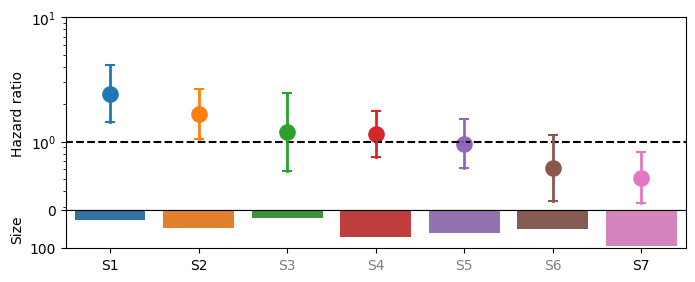

In [81]:
num_significant = 0
color_palette = sns.color_palette("tab10") + sns.color_palette("Set2")

f, ax = plt.subplots(2, 1, height_ratios=[5, 1], figsize=(8, 3), sharex=True)
f.subplots_adjust(hspace=0)
ax[0].hlines(1, -1, len(HR), color="k", linestyle="--")
N, xticklabels, xtickcolors = [], [], []
for i in range(len(HR)):
    hr_dict = HR[i]
    subgroup_id = hr_dict['subgroup_id']
    hr, hr_lb, hr_ub, p = (
            hr_dict["hr"],
            hr_dict["hr_lower"],
            hr_dict["hr_upper"],
            hr_dict["p"],
        )
    ax[0].plot([i, i], [hr_lb, hr_ub], color=color_palette[i], linewidth=2)
    ax[0].scatter([i], [hr], color=color_palette[i], s=120)
    ax[0].scatter([i], [hr_lb], color=color_palette[i], s=60, marker="_")
    ax[0].scatter([i], [hr_ub], color=color_palette[i], s=60, marker="_")
    if subgroup_id not in ['HR+/HER2-', 'HR-/HER2+', 'HR+/HER2+', 'TNBC']:
        N.append(np.sum(Subgroup_ids_ == subgroup_id))
        xticklabels.append("S{}".format(int(subgroup_id)))
    else:
        N.append(np.sum(Clinical_subtype == subgroup_id))
        xticklabels.append(subgroup_id)
    if p < 0.05:
        xtickcolors.append("k")
        num_significant+=1
    else:
        xtickcolors.append("grey")
ax[0].set_xticks(range(len(HR)))
ax[0].set_xticklabels(xticklabels)
for xtick, color in zip(ax[1].get_xticklabels(), xtickcolors):
    xtick.set_color(color)
ax[0].set_xlabel("Patient Subgroups")
ax[0].set_ylabel("Hazard ratio")
ax[0].set_yscale("log")
# ax[1].set_title("Hazard ratios of Patient Subgroups")
DF = pd.DataFrame({"N": N, "subgroup_id": xticklabels})
g = sns.barplot(data=DF, x="subgroup_id", y="N", palette=color_palette, ax=ax[1])
g.invert_yaxis()
ax[1].set_ylabel("Size")
ax[1].set_xlabel("")
ax[0].set(ylim = (0,10))
plt.show()

### Clinical Subtype

In [82]:
cph = CoxPHFitter()
Clinical_subtype = np.array([
    clinical.loc[clinical['patient_id'] == patient_id, 'Clinical Subtype'].values[0] for patient_id in Patient_IDs_
])
HR_clinical_subtype = []
for clinical_subtype in ['HR+/HER2-', 'HR-/HER2+', 'HR+/HER2+', 'TNBC']:
    DF = pd.DataFrame(
                {"length": Length, "status": Status, "community": Clinical_subtype == clinical_subtype}
            )

    cph.fit(
            DF,
            duration_col="length",
            event_col="status",
            show_progress=False,
        )
    HR_clinical_subtype.append(
            {
                "subgroup_id": clinical_subtype,
                # "status": np.array(status)[community_id == i],
                # "length": np.array(length)[community_id == i],
                "hr": cph.hazard_ratios_["community"],
                "hr_lower": np.exp(
                    cph.confidence_intervals_["95% lower-bound"]["community"]
                ),
                "hr_upper": np.exp(
                    cph.confidence_intervals_["95% upper-bound"]["community"]
                ),
                "p": cph.summary["p"]["community"],
            }
        )


/tmp/ipykernel_3902427/2409607632.py:46: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax[0].set(ylim = (0,10))


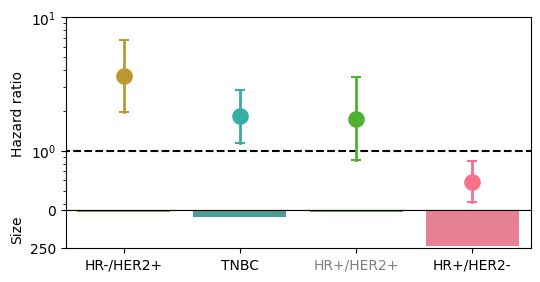

In [83]:
# Plot hazard ratio
num_significant = 0
color_palette = sns.color_palette("husl")

HR_clinical_subtype = sorted(HR_clinical_subtype, key=lambda x: x["hr"], reverse=True)
f, ax = plt.subplots(2, 1, height_ratios=[5, 1], figsize=(6, 3), sharex=True)
f.subplots_adjust(hspace=0)
ax[0].hlines(1, -1, len(HR_clinical_subtype), color="k", linestyle="--")
N, xticklabels, xtickcolors, color_palette_1 = [], [], [], []
for i in range(len(HR_clinical_subtype)):
    clinical_subtype = HR_clinical_subtype[i]['subgroup_id']
    clinical_subtype_index = ['HR+/HER2-', 'HR-/HER2+', 'HR+/HER2+', 'TNBC'].index(clinical_subtype)
    hr_dict = HR_clinical_subtype[i]
    subgroup_id = hr_dict['subgroup_id']
    hr, hr_lb, hr_ub, p = (
            hr_dict["hr"],
            hr_dict["hr_lower"],
            hr_dict["hr_upper"],
            hr_dict["p"],
        )
    ax[0].plot([i, i], [hr_lb, hr_ub], color=color_palette[clinical_subtype_index], linewidth=2)
    ax[0].scatter([i], [hr], color=color_palette[clinical_subtype_index], s=120)
    ax[0].scatter([i], [hr_lb], color=color_palette[clinical_subtype_index], s=60, marker="_")
    ax[0].scatter([i], [hr_ub], color=color_palette[clinical_subtype_index], s=60, marker="_")
    N.append(np.sum(Clinical_subtype == subgroup_id))
    xticklabels.append(subgroup_id)
    color_palette_1.append(color_palette[clinical_subtype_index])
    if p < 0.05:
        xtickcolors.append("k")
        num_significant+=1
    else:
        xtickcolors.append("grey")
ax[0].set_xticks(range(len(HR_clinical_subtype)))
ax[0].set_xticklabels(xticklabels)
for xtick, color in zip(ax[1].get_xticklabels(), xtickcolors):
    xtick.set_color(color)
ax[0].set_xlabel("Patient Subgroups")
ax[0].set_ylabel("Hazard ratio")
ax[0].set_yscale("log")
# ax[1].set_title("Hazard ratios of Patient Subgroups")
DF = pd.DataFrame({"N": N, "subgroup_id": xticklabels})
g = sns.barplot(data=DF, x="subgroup_id", y="N", palette=color_palette_1, ax=ax[1])
g.invert_yaxis()
ax[1].set_ylabel("Size")
ax[1].set_xlabel("")
ax[0].set(ylim = (0,10))
plt.show()

### Mutual Aggrement

[Text(0.5, 1.0, 'Aggrement (Intersection over Union)')]

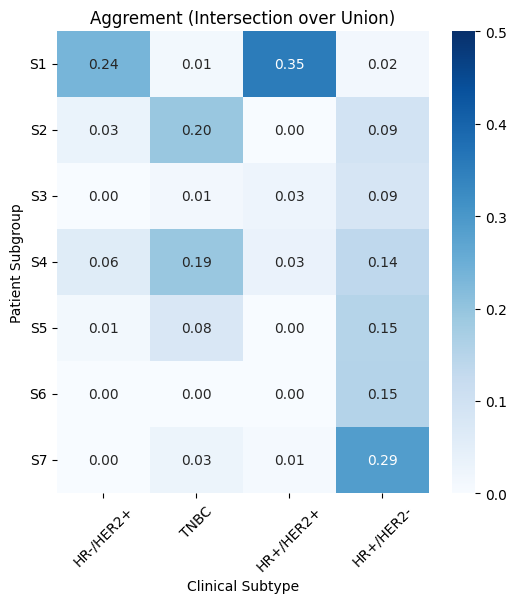

In [84]:
IOU =np.zeros((len(HR), len(HR_clinical_subtype)))
for i in range(len(HR)):
    for j in range(len(HR_clinical_subtype)):
        # print(set(np.where(Community_ids_ == HR[i]["community_id"])[0]).intersection(
        #         set(np.where(Clinical_subtype == HR_clinical_subtype[j]["subgroup_id"])[0])
        #     ))
        # print(set(np.where(Community_ids_ == HR[i]["community_id"])[0]).union(
        #         set(np.where(Clinical_subtype == HR_clinical_subtype[j]["subgroup_id"])[0])
        #     ))
        IOU[i, j] = len(
            set(np.where(Subgroup_ids_ == HR[i]["subgroup_id"])[0]).intersection(
                set(np.where(Clinical_subtype == HR_clinical_subtype[j]["subgroup_id"])[0])
            )
        ) / len(
            set(np.where(Subgroup_ids_ == HR[i]["subgroup_id"])[0]).union(
                set(np.where(Clinical_subtype == HR_clinical_subtype[j]["subgroup_id"])[0])
            )
        )
f, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(IOU, ax=ax, cmap="Blues", annot=True, fmt=".2f", vmin=0, vmax=0.5)
ax.set_xlabel("Clinical Subtype")
ax.set_ylabel("Patient Subgroup")
ax.set_yticklabels(['S'+str(hr["subgroup_id"]) for hr in HR], rotation=0)
ax.set_xticklabels([hr["subgroup_id"] for hr in HR_clinical_subtype], rotation=45)
ax.set(title = "Aggrement (Intersection over Union)")

#### S7 in HR+/HER2-

76
97
243


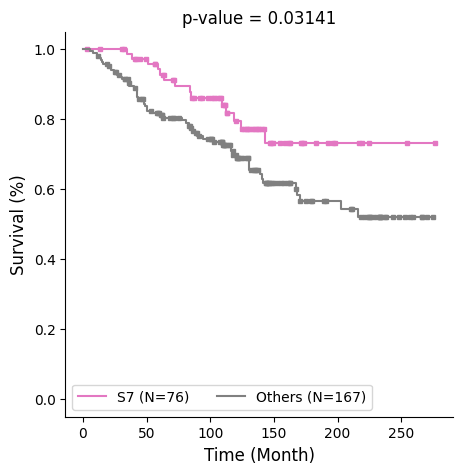

In [85]:
print(np.sum((Subgroup_ids_ == 7)&(Clinical_subtype == 'HR+/HER2-')))
print(np.sum((Subgroup_ids_ == 7)))
print(np.sum(Clinical_subtype == 'HR+/HER2-'))
color_palette = sns.color_palette("tab10") + sns.color_palette("Set2")
kmf = KaplanMeierFitter()
f, ax = plt.subplots(figsize=(5, 5))
length_A, event_observed_A = (
                Length_[(Subgroup_ids_ == 7)&(Clinical_subtype == 'HR+/HER2-')],
                Status_[(Subgroup_ids_ == 7)&(Clinical_subtype == 'HR+/HER2-')],
            )
label = "S{} (N={})".format(7, len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color=color_palette[6],
    show_censors=True,
                censor_styles={"ms": 3, "marker": "s"})

length_B, event_observed_B = (
            Length_[(Subgroup_ids_ !=7)&(Clinical_subtype == 'HR+/HER2-')],
            Status_[(Subgroup_ids_ !=7)&(Clinical_subtype == 'HR+/HER2-')],
        )
label = "Others (N={})".format( len(length_B)   )
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color='grey',
show_censors=True,
            censor_styles={"ms": 3, "marker": "s"})

log_rank_test = logrank_test(
        length_A, length_B, event_observed_A, event_observed_B
    )

p_value = log_rank_test.p_value
ax.legend(ncol=2, fontsize = 10)
ax.set_title("p-value = {:.5f}".format(p_value), fontsize = 12)
ax.set_xlabel("Time (Month)", fontsize = 12)
ax.set_ylabel("Survival (%)", fontsize = 12)
ax.set(
        ylim=(-0.05, 1.05),
    )
sns.despine()

#### S1 in HER2+

19
26
32
[220]
[ 590  607 2844  151]


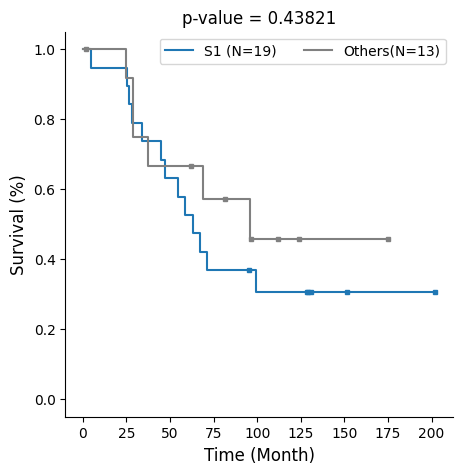

In [86]:
print(np.sum((Subgroup_ids_ == 1)*((Clinical_subtype == 'HR+/HER2+') + (Clinical_subtype == 'HR-/HER2+'))))
print(np.sum((Subgroup_ids_ == 1)))
print(np.sum(((Clinical_subtype == 'HR+/HER2+') + (Clinical_subtype == 'HR-/HER2+'))))
print(Patient_IDs[(Subgroup_ids_ == 1)*((Clinical_subtype == 'TNBC'))])
print(Patient_IDs[(Subgroup_ids_ == 1)*((Clinical_subtype == 'HR+/HER2-'))])
color_palette = sns.color_palette("tab10") + sns.color_palette("Set2")
kmf = KaplanMeierFitter()
f, ax = plt.subplots(figsize=(5, 5))
length_A, event_observed_A = (
            Length_[(Subgroup_ids_ == 1)*((Clinical_subtype == 'HR+/HER2+') + (Clinical_subtype == 'HR-/HER2+'))],
            Status_[(Subgroup_ids_ == 1)*((Clinical_subtype == 'HR+/HER2+') + (Clinical_subtype == 'HR-/HER2+'))],
        )
label = "S{} (N={})".format(1, len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color=color_palette[0],
show_censors=True,
            censor_styles={"ms": 3, "marker": "s"})

length_B, event_observed_B = (
            Length_[(Subgroup_ids_ != 1)*((Clinical_subtype == 'HR+/HER2+') + (Clinical_subtype == 'HR-/HER2+'))],
            Status_[(Subgroup_ids_ != 1)*((Clinical_subtype == 'HR+/HER2+') + (Clinical_subtype == 'HR-/HER2+'))],
        )
label = "Others(N={})".format( len(length_B)   )
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color='grey',
show_censors=True,
            censor_styles={"ms": 3, "marker": "s"})

log_rank_test = logrank_test(
        length_A, length_B, event_observed_A, event_observed_B
    )
# log_rank_test  = multivariate_logrank_test(
#         Length_[Subgroup_ids_!=0], Subgroup_ids_[Subgroup_ids_!=0],Status_[Subgroup_ids_!=0]
#     )
p_value = log_rank_test.p_value
ax.legend(ncol=2, fontsize = 10)
ax.set_title("p-value = {:.5f}".format(p_value), fontsize = 12)
ax.set_xlabel("Time (Month)", fontsize = 12)
ax.set_ylabel("Survival (%)", fontsize = 12)
ax.set(
        ylim=(-0.05, 1.05),
    )
sns.despine()

# Subset2

In [87]:
SoftWL_dict_cohort2 = pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Danenberg",
            "Subset_2",
            "Matched_SoftWL_dict_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            + "_"
            + node_label
            + "_centroid_alignment.pkl",
        ),
        "rb",
    ),
)
Patient_IDs_cohort2 = SoftWL_dict_cohort2["Patient_id"]
Histograms_cohort2 = SoftWL_dict_cohort2["Histogram"]
Histograms_cohort2 = Histograms_cohort2/np.sum(Histograms_cohort2, axis=1, keepdims=True)
clinical = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Danenberg",
        "clinical.csv",
    )
)
Patient_Inclusion_mask_cohort2 = np.ones(len(Patient_IDs_cohort2), dtype=bool)
for feature, included_values in patient_filtering_dict.items():
    Feature = [clinical.loc[clinical['patient_id'] == patient_id, feature].values[0] for patient_id in Patient_IDs_cohort2]
    patient_inclusion_mask_cohort2 = np.array([feature  == included_values for feature in Feature])
    Patient_Inclusion_mask_cohort2 = Patient_Inclusion_mask_cohort2 * patient_inclusion_mask_cohort2
Patient_IDs_cohort2 = np.array(Patient_IDs_cohort2)[Patient_Inclusion_mask_cohort2]
Histograms_cohort2 = Histograms_cohort2[Patient_Inclusion_mask_cohort2, :]
print("{} patients are included".format(len(Patient_IDs_cohort2)))

Length_cohort2 = [clinical.loc[clinical['patient_id'] == i, survival_type+' Survival (Months)'].values[0] for i in Patient_IDs_cohort2]
Status_cohort2 = [clinical.loc[clinical['patient_id'] == i, survival_type+' Survival Status'].values[0] for i in Patient_IDs_cohort2]  
DF_cohort2 = pd.DataFrame({"Length": Length_cohort2, "Status": Status_cohort2}).dropna()
Length_cohort2_ = np.array(DF_cohort2["Length"])
Status_cohort2_ = np.array(DF_cohort2["Status"])
Histograms_cohort2_ = Histograms_cohort2[DF_cohort2.index.values, :]
Patient_IDs_cohort2_ = np.array(Patient_IDs_cohort2)[DF_cohort2.index.values]

200 patients are included


#### Clinical Subtype

In [88]:
cph = CoxPHFitter()
Clinical_subtype = np.array([
    clinical.loc[clinical['patient_id'] == patient_id, 'Clinical Subtype'].values[0] for patient_id in Patient_IDs_cohort2_
])
clinical_subtype_names = [
    HR_clinical_subtype[i]['subgroup_id'] for i in range(len(HR_clinical_subtype))
]
HR_clinical_subtype = []
for clinical_subtype in clinical_subtype_names:
    DF = pd.DataFrame(
                {"length": Length_cohort2_, "status": Status_cohort2_, "community": Clinical_subtype == clinical_subtype}
            )

    cph.fit(
            DF,
            duration_col="length",
            event_col="status",
            show_progress=False,
        )
    HR_clinical_subtype.append(
            {
                "subgroup_id": clinical_subtype,
                # "status": np.array(status)[community_id == i],
                # "length": np.array(length)[community_id == i],
                "hr": cph.hazard_ratios_["community"],
                "hr_lower": np.exp(
                    cph.confidence_intervals_["95% lower-bound"]["community"]
                ),
                "hr_upper": np.exp(
                    cph.confidence_intervals_["95% upper-bound"]["community"]
                ),
                "p": cph.summary["p"]["community"],
            }
        )


/tmp/ipykernel_3902427/105620139.py:44: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax[0].set(ylim = (0,10))


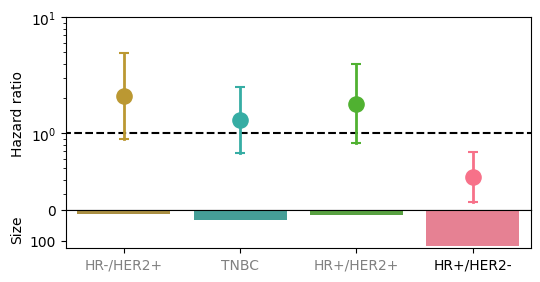

In [89]:
# Plot hazard ratio
num_significant = 0
color_palette = sns.color_palette("husl")
f, ax = plt.subplots(2, 1, height_ratios=[5, 1], figsize=(6, 3), sharex=True)
f.subplots_adjust(hspace=0)
ax[0].hlines(1, -1, len(HR_clinical_subtype), color="k", linestyle="--")
N, xticklabels, xtickcolors, color_palette_1 = [], [], [], []
for i in range(len(HR_clinical_subtype)):
    clinical_subtype = HR_clinical_subtype[i]['subgroup_id']
    clinical_subtype_index = ['HR+/HER2-', 'HR-/HER2+', 'HR+/HER2+', 'TNBC'].index(clinical_subtype)
    hr_dict = HR_clinical_subtype[i]
    subgroup_id = hr_dict['subgroup_id']
    hr, hr_lb, hr_ub, p = (
            hr_dict["hr"],
            hr_dict["hr_lower"],
            hr_dict["hr_upper"],
            hr_dict["p"],
        )
    ax[0].plot([i, i], [hr_lb, hr_ub], color=color_palette[clinical_subtype_index], linewidth=2)
    ax[0].scatter([i], [hr], color=color_palette[clinical_subtype_index], s=120)
    ax[0].scatter([i], [hr_lb], color=color_palette[clinical_subtype_index], s=60, marker="_")
    ax[0].scatter([i], [hr_ub], color=color_palette[clinical_subtype_index], s=60, marker="_")
    N.append(np.sum(Clinical_subtype == subgroup_id))
    xticklabels.append(subgroup_id)
    color_palette_1.append(color_palette[clinical_subtype_index])
    if p < 0.05:
        xtickcolors.append("k")
        num_significant+=1
    else:
        xtickcolors.append("grey")
ax[0].set_xticks(range(len(HR_clinical_subtype)))
ax[0].set_xticklabels(xticklabels)
for xtick, color in zip(ax[1].get_xticklabels(), xtickcolors):
    xtick.set_color(color)
ax[0].set_xlabel("Patient Subgroups")
ax[0].set_ylabel("Hazard ratio")
ax[0].set_yscale("log")
# ax[1].set_title("Hazard ratios of Patient Subgroups")
DF = pd.DataFrame({"N": N, "subgroup_id": xticklabels})
g = sns.barplot(data=DF, x="subgroup_id", y="N", palette=color_palette_1, ax=ax[1])
g.invert_yaxis()
ax[1].set_ylabel("Size")
ax[1].set_xlabel("")
ax[0].set(ylim = (0,10))
plt.show()

### BiGraph

In [90]:
from b_Soft_WL_Kernel_random_split.SoftWL import get_Gram_matrix
from Alignment import centroid_alignment_based_on_similarity
Gram_matrix_cohort2_ = get_Gram_matrix(Histograms_cohort2_)

Indices = np.zeros(len(Histograms_), dtype=bool)
Similarity_cohort2_discovery = get_Gram_matrix(np.concatenate([Histograms_cohort2_, Histograms_], axis=0))
Similarity_cohort2_discovery = Similarity_cohort2_discovery[:Histograms_cohort2_.shape[0], :][:, Histograms_cohort2_.shape[0]:]
assert Similarity_cohort2_discovery.shape[0] == Histograms_cohort2_.shape[0]
Subgroup_ids_cohort2_ = centroid_alignment_based_on_similarity(Similarity_cohort2_discovery, Subgroup_ids_, k=0)
print("{} patients are included".format(len(Patient_IDs_cohort2_)))

0.24216635256990027
200 patients are included


In [91]:
Length = [clinical.loc[clinical['patient_id'] == i, survival_type+ ' Survival (Months)'].values[0] for i in Patient_IDs_cohort2_]
Status = [clinical.loc[clinical['patient_id'] == i,  survival_type+ ' Survival Status'].values[0] for i in Patient_IDs_cohort2_]  
HR = []
for i in range(Subgroup_ids_cohort2_.shape[1]):
    HR_ = calculate_hazard_ratio(Length, Status, Subgroup_ids_cohort2_[:,i])
    # print(HR_)
    HR.append({
        'subgroup_id': i + 1,
        'hr': HR_[0]['hr'],
        'hr_lower': HR_[0]['hr_lower'],
        'hr_upper': HR_[0]['hr_upper'],
        'p': HR_[0]['p']

    })

for i in range(len(HR)):
    print("S{} (N = {}):".format(HR[i]['subgroup_id'], np.sum(Subgroup_ids_cohort2_[:,i] ==1)))
    print("Survival: hr = {}, p = {}".format(HR[i]["hr"], HR[i]["p"]))
    if HR[i]["p"] < 0.05/len(HR):
        print("\tSignificant")

S1 (N = 27):
Survival: hr = 2.187109830782813, p = 0.01201173548007851
S2 (N = 9):
Survival: hr = 0.8513265981060354, p = 0.7856536493809319
S3 (N = 8):
Survival: hr = 0.3236454558764104, p = 0.2631633853252724
S4 (N = 42):
Survival: hr = 1.6931189282178551, p = 0.05443965944359487
S5 (N = 17):
Survival: hr = 1.033436960023265, p = 0.9389556461607504
S6 (N = 23):
Survival: hr = 0.8857252618638314, p = 0.7619711233130296
S7 (N = 48):
Survival: hr = 0.4949395488994675, p = 0.041280097864249556


### Mutual agreement

[Text(0.5, 1.0, 'Agreement (Intersection over Union)')]

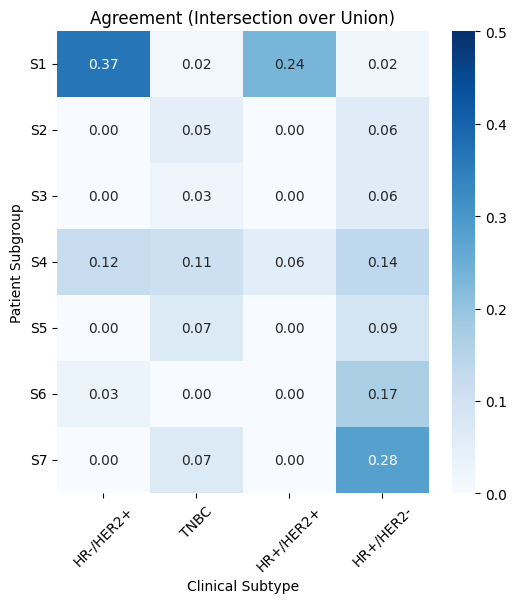

In [92]:

IOU =np.zeros((len(HR), len(HR_clinical_subtype)))
for i in range(len(HR)):
    for j in range(len(HR_clinical_subtype)):
        # print(set(np.where(Subgroup_ids_cohort2_ [:,HR[i]["subgroup_id"]] == 1)[0]).intersection(
        #         set(np.where(Clinical_subtype == HR_clinical_subtype[j]["subgroup_id"])[0])
        #     ))
        # print(set(np.where(Subgroup_ids_cohort2_ [:,HR[i]["subgroup_id"]] == 1)[0]).union(
        #         set(np.where(Clinical_subtype == HR_clinical_subtype[j]["subgroup_id"])[0])
        #     ))
        IOU[i, j] = len(
            set(np.where(Subgroup_ids_cohort2_ [:,HR[i]["subgroup_id"]-1] == 1)[0]).intersection(
                set(np.where(Clinical_subtype == HR_clinical_subtype[j]["subgroup_id"])[0])
            )
        ) / len(
            set(np.where(Subgroup_ids_cohort2_ [:,HR[i]["subgroup_id"]-1] == 1)[0]).union(
                set(np.where(Clinical_subtype == HR_clinical_subtype[j]["subgroup_id"])[0])
            )
        )
f, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(IOU, ax=ax, cmap="Blues", annot=True, fmt=".2f", vmin=0, vmax=0.5)
ax.set_xlabel("Clinical Subtype")
ax.set_ylabel("Patient Subgroup")
ax.set_yticklabels(['S'+str(hr["subgroup_id"]) for hr in HR], rotation=0)
ax.set_xticklabels([hr["subgroup_id"] for hr in HR_clinical_subtype], rotation=45)
ax.set(title = "Agreement (Intersection over Union)")

#### S7 in HR+/HER2-

36
48
116


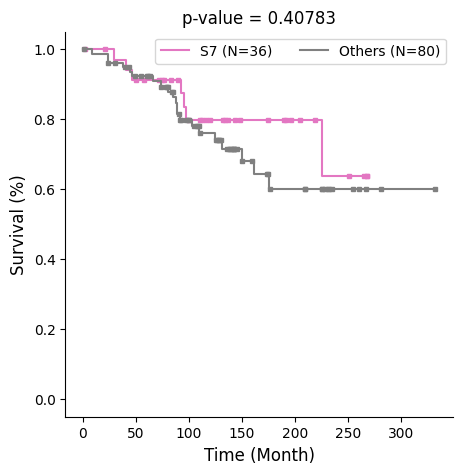

In [93]:
Clinical_subtype = np.array([
    clinical.loc[clinical['patient_id'] == patient_id, 'Clinical Subtype'].values[0] for patient_id in Patient_IDs_cohort2_

])
print(np.sum((Subgroup_ids_cohort2_[:,6] == 1)&(Clinical_subtype == 'HR+/HER2-')))
print(np.sum((Subgroup_ids_cohort2_[:,6] == 1)))
print(np.sum(Clinical_subtype == 'HR+/HER2-'))
color_palette = sns.color_palette("tab10") + sns.color_palette("Set2")
kmf = KaplanMeierFitter()
f, ax = plt.subplots(figsize=(5, 5))
length_A, event_observed_A = (
                Length_cohort2_[(Subgroup_ids_cohort2_[:,6] == 1)&(Clinical_subtype == 'HR+/HER2-')],
                Status_cohort2_[(Subgroup_ids_cohort2_[:,6] == 1)&(Clinical_subtype == 'HR+/HER2-')],
            )
label = "S{} (N={})".format(7, len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color=color_palette[6],
    show_censors=True,
                censor_styles={"ms": 3, "marker": "s"})

length_B, event_observed_B = (
            Length_cohort2_[(Subgroup_ids_cohort2_[:,6] !=1)&(Clinical_subtype == 'HR+/HER2-')],
            Status_cohort2_[(Subgroup_ids_cohort2_[:,6] !=1)&(Clinical_subtype == 'HR+/HER2-')],
        )
label = "Others (N={})".format( len(length_B)   )
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color='grey',
show_censors=True,
            censor_styles={"ms": 3, "marker": "s"})

log_rank_test = logrank_test(
        length_A, length_B, event_observed_A, event_observed_B
    )

p_value = log_rank_test.p_value
ax.legend(ncol=2, fontsize = 10)
ax.set_title("p-value = {:.5f}".format(p_value), fontsize = 12)
ax.set_xlabel("Time (Month)", fontsize = 12)
ax.set_ylabel("Survival (%)", fontsize = 12)
ax.set(
        ylim=(-0.05, 1.05),
    )
sns.despine()

#### S1 in HER2+

19
27
29


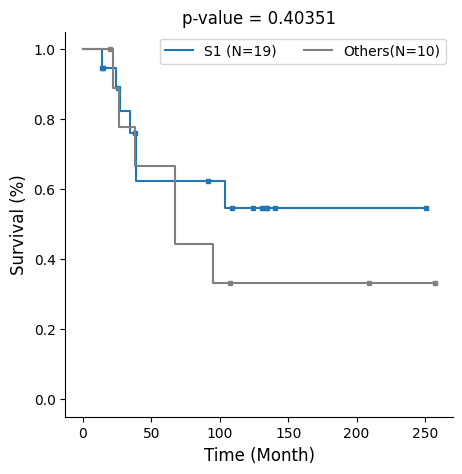

In [97]:
print(np.sum((Subgroup_ids_cohort2_[:,0] == 1)*((Clinical_subtype == 'HR+/HER2+') + (Clinical_subtype == 'HR-/HER2+'))))
print(np.sum((Subgroup_ids_cohort2_[:,0] == 1)))
print(np.sum(((Clinical_subtype == 'HR+/HER2+') + (Clinical_subtype == 'HR-/HER2+'))))

color_palette = sns.color_palette("tab10") + sns.color_palette("Set2")
kmf = KaplanMeierFitter()
f, ax = plt.subplots(figsize=(5, 5))
length_A, event_observed_A = (
            Length_cohort2_[(Subgroup_ids_cohort2_[:,0] == 1)*((Clinical_subtype == 'HR+/HER2+') + (Clinical_subtype == 'HR-/HER2+'))],
            Status_cohort2_[(Subgroup_ids_cohort2_[:,0] == 1)*((Clinical_subtype == 'HR+/HER2+') + (Clinical_subtype == 'HR-/HER2+'))],
        )
label = "S{} (N={})".format(1, len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color=color_palette[0],
show_censors=True,
            censor_styles={"ms": 3, "marker": "s"})

length_B, event_observed_B = (
            Length_cohort2_[(Subgroup_ids_cohort2_[:,0] != 1)*((Clinical_subtype == 'HR+/HER2+') + (Clinical_subtype == 'HR-/HER2+'))],
            Status_cohort2_[(Subgroup_ids_cohort2_[:,0] != 1)*((Clinical_subtype == 'HR+/HER2+') + (Clinical_subtype == 'HR-/HER2+'))],
        )
label = "Others(N={})".format( len(length_B)   )
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color='grey',
show_censors=True,
            censor_styles={"ms": 3, "marker": "s"})

log_rank_test = logrank_test(
        length_A, length_B, event_observed_A, event_observed_B
    )
# log_rank_test  = multivariate_logrank_test(
#         Length_[Subgroup_ids_!=0], Subgroup_ids_[Subgroup_ids_!=0],Status_[Subgroup_ids_!=0]
#     )
p_value = log_rank_test.p_value
ax.legend(ncol=2, fontsize = 10)
ax.set_title("p-value = {:.5f}".format(p_value), fontsize = 12)
ax.set_xlabel("Time (Month)", fontsize = 12)
ax.set_ylabel("Survival (%)", fontsize = 12)
ax.set(
        ylim=(-0.05, 1.05),
    )
sns.despine()

# Jackson

In [98]:
from utils import process_Jackson_clinical_data
survival_type_jackson = "Overall"
SoftWL_dict_jackson = pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Jackson",
            "Matched_SoftWL_dict_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            + "_"
            + node_label
            + "_centroid_alignment.pkl",
        ),
        "rb",
    ),
)
Patient_IDs_jackson = SoftWL_dict_jackson["Patient_id"]
Histograms_jackson = SoftWL_dict_jackson["Histogram"]
Histograms_jackson = Histograms_jackson/np.sum(Histograms_jackson, axis=1, keepdims=True)
clinical = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Jackson",
        "clinical.csv",
    )
)
clinical = process_Jackson_clinical_data(clinical)

Patient_Inclusion_mask_jackson = np.ones(len(Patient_IDs_jackson), dtype=bool)
for feature, included_values in patient_filtering_dict.items():
    Feature = [clinical.loc[clinical['patient_id'] == patient_id, feature].values[0] for patient_id in Patient_IDs_jackson]
    patient_inclusion_mask_jackson = np.array([feature  == included_values for feature in Feature])
    Patient_Inclusion_mask_jackson = Patient_Inclusion_mask_jackson * patient_inclusion_mask_jackson
Patient_IDs_jackson = np.array(Patient_IDs_jackson)[Patient_Inclusion_mask_jackson]
Histograms_jackson = Histograms_jackson[Patient_Inclusion_mask_jackson, :]

Length_jackson = [
        clinical.loc[clinical["patient_id"] == i, survival_type_jackson+" Survival (Months)"].values[0]
        for i in Patient_IDs_jackson
    ]
Status_jackson = [
        clinical.loc[clinical["patient_id"] == i, survival_type_jackson+" Survival Status"].values[0]
        for i in Patient_IDs_jackson
    ]

DF_jackson = pd.DataFrame({"Length": Length_jackson, "Status": Status_jackson}).dropna()
Length_jackson_ = np.array(DF_jackson["Length"])
Status_jackson_ = np.array(DF_jackson["Status"])
Histograms_jackson_ = Histograms_jackson[DF_jackson.index.values, :]
Patient_IDs_jackson_ = np.array(Patient_IDs_jackson)[DF_jackson.index.values]


### Clinical Subtype

In [99]:
cph = CoxPHFitter()
Clinical_subtype = np.array([
    clinical.loc[clinical['patient_id'] == patient_id, 'Clinical Subtype'].values[0] for patient_id in Patient_IDs_jackson_
])
clinical_subtype_names = [
    HR_clinical_subtype[i]['subgroup_id'] for i in range(len(HR_clinical_subtype))
]
HR_clinical_subtype = []
for clinical_subtype in clinical_subtype_names:
    DF = pd.DataFrame(
                {"length": Length_jackson_, "status": Status_jackson_, "community": Clinical_subtype == clinical_subtype}
            )

    cph.fit(
            DF,
            duration_col="length",
            event_col="status",
            show_progress=False,
        )
    HR_clinical_subtype.append(
            {
                "subgroup_id": clinical_subtype,
                # "status": np.array(status)[community_id == i],
                # "length": np.array(length)[community_id == i],
                "hr": cph.hazard_ratios_["community"],
                "hr_lower": np.exp(
                    cph.confidence_intervals_["95% lower-bound"]["community"]
                ),
                "hr_upper": np.exp(
                    cph.confidence_intervals_["95% upper-bound"]["community"]
                ),
                "p": cph.summary["p"]["community"],
            }
        )


/tmp/ipykernel_3902427/105620139.py:44: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax[0].set(ylim = (0,10))


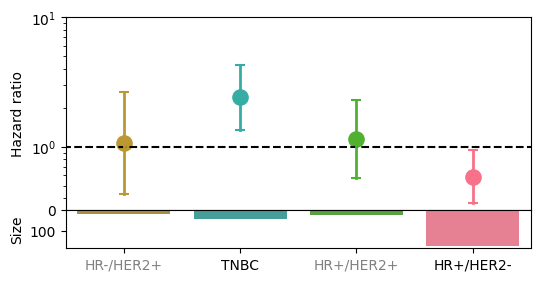

In [100]:
# Plot hazard ratio
num_significant = 0
color_palette = sns.color_palette("husl")
f, ax = plt.subplots(2, 1, height_ratios=[5, 1], figsize=(6, 3), sharex=True)
f.subplots_adjust(hspace=0)
ax[0].hlines(1, -1, len(HR_clinical_subtype), color="k", linestyle="--")
N, xticklabels, xtickcolors, color_palette_1 = [], [], [], []
for i in range(len(HR_clinical_subtype)):
    clinical_subtype = HR_clinical_subtype[i]['subgroup_id']
    clinical_subtype_index = ['HR+/HER2-', 'HR-/HER2+', 'HR+/HER2+', 'TNBC'].index(clinical_subtype)
    hr_dict = HR_clinical_subtype[i]
    subgroup_id = hr_dict['subgroup_id']
    hr, hr_lb, hr_ub, p = (
            hr_dict["hr"],
            hr_dict["hr_lower"],
            hr_dict["hr_upper"],
            hr_dict["p"],
        )
    ax[0].plot([i, i], [hr_lb, hr_ub], color=color_palette[clinical_subtype_index], linewidth=2)
    ax[0].scatter([i], [hr], color=color_palette[clinical_subtype_index], s=120)
    ax[0].scatter([i], [hr_lb], color=color_palette[clinical_subtype_index], s=60, marker="_")
    ax[0].scatter([i], [hr_ub], color=color_palette[clinical_subtype_index], s=60, marker="_")
    N.append(np.sum(Clinical_subtype == subgroup_id))
    xticklabels.append(subgroup_id)
    color_palette_1.append(color_palette[clinical_subtype_index])
    if p < 0.05:
        xtickcolors.append("k")
        num_significant+=1
    else:
        xtickcolors.append("grey")
ax[0].set_xticks(range(len(HR_clinical_subtype)))
ax[0].set_xticklabels(xticklabels)
for xtick, color in zip(ax[1].get_xticklabels(), xtickcolors):
    xtick.set_color(color)
ax[0].set_xlabel("Patient Subgroups")
ax[0].set_ylabel("Hazard ratio")
ax[0].set_yscale("log")
# ax[1].set_title("Hazard ratios of Patient Subgroups")
DF = pd.DataFrame({"N": N, "subgroup_id": xticklabels})
g = sns.barplot(data=DF, x="subgroup_id", y="N", palette=color_palette_1, ax=ax[1])
g.invert_yaxis()
ax[1].set_ylabel("Size")
ax[1].set_xlabel("")
ax[0].set(ylim = (0,10))
plt.show()

### BiGraph

In [101]:
from b_Soft_WL_Kernel_random_split.SoftWL import get_Gram_matrix
from Alignment import centroid_alignment_based_on_similarity
Gram_matrix_jackson_ = get_Gram_matrix(Histograms_jackson_)

Indices = np.zeros(len(Histograms_), dtype=bool)
Similarity_jackson_discovery = get_Gram_matrix(np.concatenate([Histograms_jackson_, Histograms_], axis=0))
Similarity_jackson_discovery = Similarity_jackson_discovery[:Histograms_jackson_.shape[0], :][:, Histograms_jackson_.shape[0]:]
assert Similarity_jackson_discovery.shape[0] == Histograms_jackson_.shape[0]
Subgroup_ids_jackson_ = centroid_alignment_based_on_similarity(Similarity_jackson_discovery, Subgroup_ids_, k=0)
print("{} patients are included".format(len(Patient_IDs_jackson_)))

0.20101924103834184
266 patients are included


In [102]:
Length = [clinical.loc[clinical['patient_id'] == i, 'Overall Survival (Months)'].values[0] for i in Patient_IDs_jackson_]
Status = [clinical.loc[clinical['patient_id'] == i,  'Overall Survival Status'].values[0] for i in Patient_IDs_jackson_]  
HR = []
for i in range(Subgroup_ids_jackson_.shape[1]):
    HR_ = calculate_hazard_ratio(Length, Status, Subgroup_ids_jackson_[:,i])
    # print(HR_)
    HR.append({
        'subgroup_id': i + 1,
        'hr': HR_[0]['hr'],
        'hr_lower': HR_[0]['hr_lower'],
        'hr_upper': HR_[0]['hr_upper'],
        'p': HR_[0]['p']

    })

for i in range(len(HR)):
    print("S{} (N = {}):".format(HR[i]['subgroup_id'], np.sum(Subgroup_ids_jackson_[:,i] ==1)))
    print("Survival: hr = {}, p = {}".format(HR[i]["hr"], HR[i]["p"]))
    if HR[i]["p"] < 0.05/len(HR):
        print("\tSignificant")

S1 (N = 33):
Survival: hr = 1.930223035119079, p = 0.022422873334102776
S2 (N = 28):
Survival: hr = 0.8186752650696205, p = 0.5941540556031235
S3 (N = 32):
Survival: hr = 1.035456888766876, p = 0.918288065843603
S4 (N = 77):
Survival: hr = 0.8329580058844964, p = 0.4906185749552656
S5 (N = 28):
Survival: hr = 0.8043909211685868, p = 0.5850793884097862
S6 (N = 17):
Survival: hr = 0.977751367504157, p = 0.9612436538484568
S7 (N = 56):
Survival: hr = 0.4640162532751389, p = 0.02419555942328183


### Mutual agreement

[Text(0.5, 1.0, 'Agreement (Intersection over Union)')]

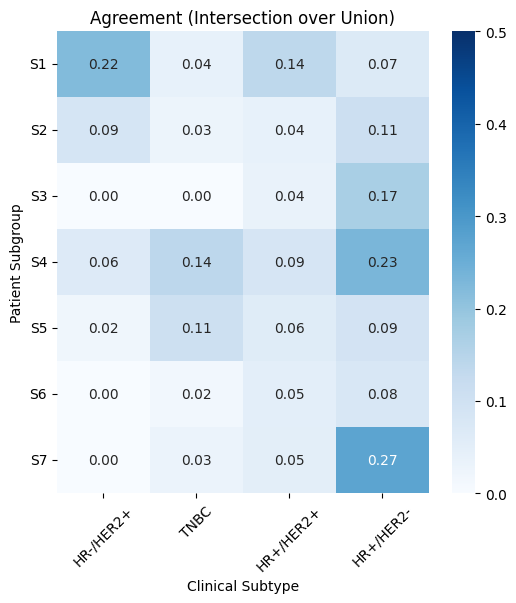

In [103]:

IOU =np.zeros((len(HR), len(HR_clinical_subtype)))
for i in range(len(HR)):
    for j in range(len(HR_clinical_subtype)):
        IOU[i, j] = len(
            set(np.where(Subgroup_ids_jackson_ [:,HR[i]["subgroup_id"]-1] == 1)[0]).intersection(
                set(np.where(Clinical_subtype == HR_clinical_subtype[j]["subgroup_id"])[0])
            )
        ) / len(
            set(np.where(Subgroup_ids_jackson_ [:,HR[i]["subgroup_id"]-1] == 1)[0]).union(
                set(np.where(Clinical_subtype == HR_clinical_subtype[j]["subgroup_id"])[0])
            )
        )
f, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(IOU, ax=ax, cmap="Blues", annot=True, fmt=".2f", vmin=0, vmax=0.5)
ax.set_xlabel("Clinical Subtype")
ax.set_ylabel("Patient Subgroup")
ax.set_yticklabels(['S'+str(hr["subgroup_id"]) for hr in HR], rotation=0)
ax.set_xticklabels([hr["subgroup_id"] for hr in HR_clinical_subtype], rotation=45)
ax.set(title = "Agreement (Intersection over Union)")

49
56
173


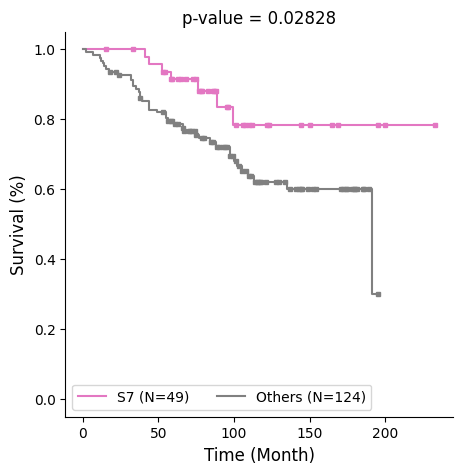

In [104]:
Clinical_subtype = np.array([
    clinical.loc[clinical['patient_id'] == patient_id, 'Clinical Subtype'].values[0] for patient_id in Patient_IDs_jackson_

])
print(np.sum((Subgroup_ids_jackson_[:,6] == 1)&(Clinical_subtype == 'HR+/HER2-')))
print(np.sum((Subgroup_ids_jackson_[:,6] == 1)))
print(np.sum(Clinical_subtype == 'HR+/HER2-'))
color_palette = sns.color_palette("tab10") + sns.color_palette("Set2")
kmf = KaplanMeierFitter()
f, ax = plt.subplots(figsize=(5, 5))
length_A, event_observed_A = (
                Length_jackson_[(Subgroup_ids_jackson_[:,6] == 1)&(Clinical_subtype == 'HR+/HER2-')],
                Status_jackson_[(Subgroup_ids_jackson_[:,6] == 1)&(Clinical_subtype == 'HR+/HER2-')],
            )
label = "S{} (N={})".format(7, len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color=color_palette[6],
    show_censors=True,
                censor_styles={"ms": 3, "marker": "s"})

length_B, event_observed_B = (
            Length_jackson_[(Subgroup_ids_jackson_[:,6] !=1)&(Clinical_subtype == 'HR+/HER2-')],
            Status_jackson_[(Subgroup_ids_jackson_[:,6] !=1)&(Clinical_subtype == 'HR+/HER2-')],
        )
label = "Others (N={})".format( len(length_B)   )
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color='grey',
show_censors=True,
            censor_styles={"ms": 3, "marker": "s"})

log_rank_test = logrank_test(
        length_A, length_B, event_observed_A, event_observed_B
    )

p_value = log_rank_test.p_value
ax.legend(ncol=2, fontsize = 10)
ax.set_title("p-value = {:.5f}".format(p_value), fontsize = 12)
ax.set_xlabel("Time (Month)", fontsize = 12)
ax.set_ylabel("Survival (%)", fontsize = 12)
ax.set(
        ylim=(-0.05, 1.05),
    )
sns.despine()

#### S1 in HER2+

17
33
47


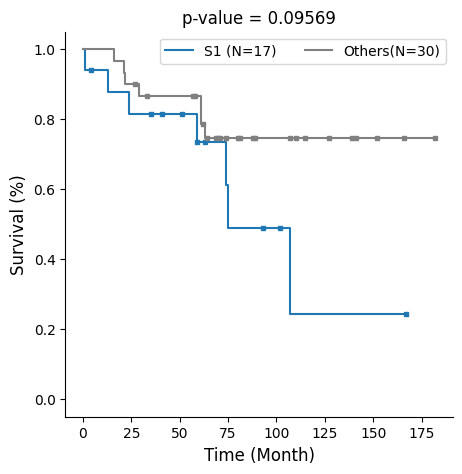

In [106]:
print(np.sum((Subgroup_ids_jackson_[:,0] == 1)*((Clinical_subtype == 'HR+/HER2+') + (Clinical_subtype == 'HR-/HER2+'))))
print(np.sum((Subgroup_ids_jackson_[:,0] == 1)))
print(np.sum(((Clinical_subtype == 'HR+/HER2+') + (Clinical_subtype == 'HR-/HER2+'))))

color_palette = sns.color_palette("tab10") + sns.color_palette("Set2")
kmf = KaplanMeierFitter()
f, ax = plt.subplots(figsize=(5, 5))
length_A, event_observed_A = (
            Length_jackson_[(Subgroup_ids_jackson_[:,0] == 1)*((Clinical_subtype == 'HR+/HER2+') + (Clinical_subtype == 'HR-/HER2+'))],
            Status_jackson_[(Subgroup_ids_jackson_[:,0] == 1)*((Clinical_subtype == 'HR+/HER2+') + (Clinical_subtype == 'HR-/HER2+'))],
        )
label = "S{} (N={})".format(1, len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color=color_palette[0],
show_censors=True,
            censor_styles={"ms": 3, "marker": "s"})

length_B, event_observed_B = (
            Length_jackson_[(Subgroup_ids_jackson_[:,0] != 1)*((Clinical_subtype == 'HR+/HER2+') + (Clinical_subtype == 'HR-/HER2+'))],
            Status_jackson_[(Subgroup_ids_jackson_[:,0] != 1)*((Clinical_subtype == 'HR+/HER2+') + (Clinical_subtype == 'HR-/HER2+'))],
        )
label = "Others(N={})".format( len(length_B)   )
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color='grey',
show_censors=True,
            censor_styles={"ms": 3, "marker": "s"})

log_rank_test = logrank_test(
        length_A, length_B, event_observed_A, event_observed_B
    )
# log_rank_test  = multivariate_logrank_test(
#         Length_[Subgroup_ids_!=0], Subgroup_ids_[Subgroup_ids_!=0],Status_[Subgroup_ids_!=0]
#     )
p_value = log_rank_test.p_value
ax.legend(ncol=2, fontsize = 10)
ax.set_title("p-value = {:.5f}".format(p_value), fontsize = 12)
ax.set_xlabel("Time (Month)", fontsize = 12)
ax.set_ylabel("Survival (%)", fontsize = 12)
ax.set(
        ylim=(-0.05, 1.05),
    )
sns.despine()